In [9]:
import torchvision
import torch
from torchvision.models.detection import ssdlite, ssdlite320_mobilenet_v3_large

model = ssdlite320_mobilenet_v3_large(weights=None, num_classes=3) # we do not specify pretrained=True, i.e. do not load default weights
#model.load_state_dict(torch.load(''))


checkpoint = torch.load("model_opt_adam_epochs_40_train_backbone_False_lr_0.01_lrstepsize_8_lrgamma_0.1_mom_0.9_final.pth")
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

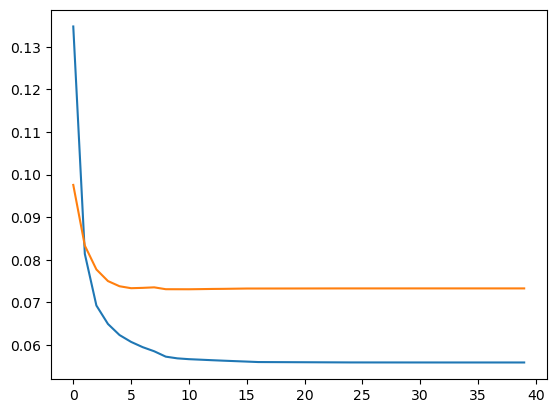

In [67]:
plt.plot(checkpoint["losses_train"])
plt.plot(checkpoint["losses_val"])

In [22]:
from torch.utils.data import DataLoader
from src.dataLoading import playersDataset, collate_fn   # these are custom for our dataset


# set the device (GPU is much faster)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_workers = 1 if torch.cuda.is_available() else 0
batch_size = 1 # LOWER THIS IF NEEDED!

train_dir = "Data/train/"
valid_dir = "Data/valid/"
test_dir = "Data/valid/"
train_dataset = playersDataset(train_dir)
validation_dataset = playersDataset(valid_dir)
test_dataset = playersDataset(test_dir)

# Define the dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [13]:
from Evaluation.engine import evaluate

model.to(device)
evaluate(model=model, data_loader=test_loader, device=device)

creating index...
index created!
Test:  [ 0/56]  eta: 0:10:09  model_time: 9.3736 (9.3736)  evaluator_time: 0.4236 (0.4236)  time: 10.8907  data: 0.1583  max mem: 268
Test:  [55/56]  eta: 0:00:00  model_time: 0.0810 (0.2473)  evaluator_time: 0.2369 (0.3092)  time: 0.5302  data: 0.1789  max mem: 268
Test: Total time: 0:00:42 (0.7640 s / it)
Averaged stats: model_time: 0.0810 (0.2473)  evaluator_time: 0.2369 (0.3092)
Accumulating evaluation results...
DONE (t=0.64s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0

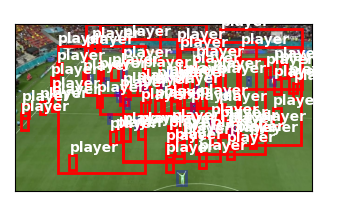

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_imgs(imgs, annotations, true_annotations, rows, cols, tensors=False):
    CLASSES = ["","ball", "player"]
    fig = plt.figure(figsize=(20,10))
    
    for i in range(len(imgs)):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])

        boxes = annotations[i]['boxes']
        true_boxes = true_annotations[i]['boxes']
        labels = annotations[i]['labels']
        scores = annotations[i]['scores']
        img = None

        # threshold the predictions
        thresholded_preds_inidices = [i for i in scores if i > 0.25]
        thresholded_preds_count = len(thresholded_preds_inidices)

        boxes = boxes[:thresholded_preds_count]
        labels = labels[:thresholded_preds_count]


        if(tensors):
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        else:
            img = imgs[i].numpy().transpose(1, 2, 0)
        ax.imshow(img, origin='upper')

        for j, (box, score) in enumerate(zip(boxes, scores)):
            if(score < 0.25):
                continue
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='r', facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')
        
        for j, box in enumerate(true_boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='b', alpha=0.3, facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            # ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')

    plt.show()


model.eval()
images, targets = next(iter(test_loader))
images = list(image.to(device) for image in images)
preds = model(images)
fig = visualize_imgs(images, preds, targets, rows=4, cols=4, tensors=True)